In [23]:
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from keras.utils import to_categorical


In [24]:
random_state = 2860 #5085
data = pd.read_csv('Data/encoded_data.csv')

In [25]:
X = data.drop(columns=['Output','X16'])  
y = data['Output']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

In [26]:
import joblib

# Train the RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=random_state)
random_forest.fit(X_train, y_train)

# Make predictions
rf_predictions = random_forest.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, rf_predictions)
precision = precision_score(y_test, rf_predictions)
recall = recall_score(y_test, rf_predictions)
f1 = f1_score(y_test, rf_predictions)

print("Accuracy:", accuracy)

# Define evaluation metrics dictionary
rf_metrics = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1
}

# Get feature names from X_train
feature_names = X_train.columns.tolist()

# Save the trained model, feature names, and evaluation metrics using joblib
joblib.dump((random_forest, feature_names), 'Models/random_forest_model.pkl')


Accuracy: 0.9538461538461539


['Models/random_forest_model.pkl']

In [27]:
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

nn_model = Sequential([
    Input(shape=(X_train.shape[1],)),  
    Dense(256, activation='relu'),  
    Dense(128, activation='relu'),  
    Dense(64, activation='relu'),
    Dense(2, activation='sigmoid')  
])


nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


history = nn_model.fit(X_train, y_train_encoded, epochs=100, batch_size=32, validation_split=0.1, verbose=0)
nn_predictions = nn_model.predict(X_test).argmax(axis=1)


accuracy = accuracy_score(y_test, nn_predictions)
precision = precision_score(y_test, nn_predictions)
recall = recall_score(y_test, nn_predictions)
f1 = f1_score(y_test, nn_predictions)

print("Test Accuracy:", accuracy)

nn_metrics = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1
}

nn_model.save('Models/neural_network_model.h5')

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002640CB60CC0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Test Accuracy: 0.7230769230769231


In [28]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm_model = SVC(kernel='sigmoid', random_state=random_state)
svm_model.fit(X_train_scaled, y_train)

svm_predictions = svm_model.predict(X_test_scaled)


accuracy = accuracy_score(y_test, svm_predictions)
precision = precision_score(y_test, svm_predictions)
recall = recall_score(y_test, svm_predictions)
f1 = f1_score(y_test, svm_predictions)

print("Accuracy:", accuracy)


svm_metrics = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1
}

joblib.dump((svm_model, scaler, svm_metrics), 'Models/svm_model.pkl')


Accuracy: 0.9384615384615385


['Models/svm_model.pkl']

In [29]:
rf_cm = confusion_matrix(y_test, rf_predictions)
nn_cm = confusion_matrix(y_test, nn_predictions)
svm_cm = confusion_matrix(y_test, svm_predictions)

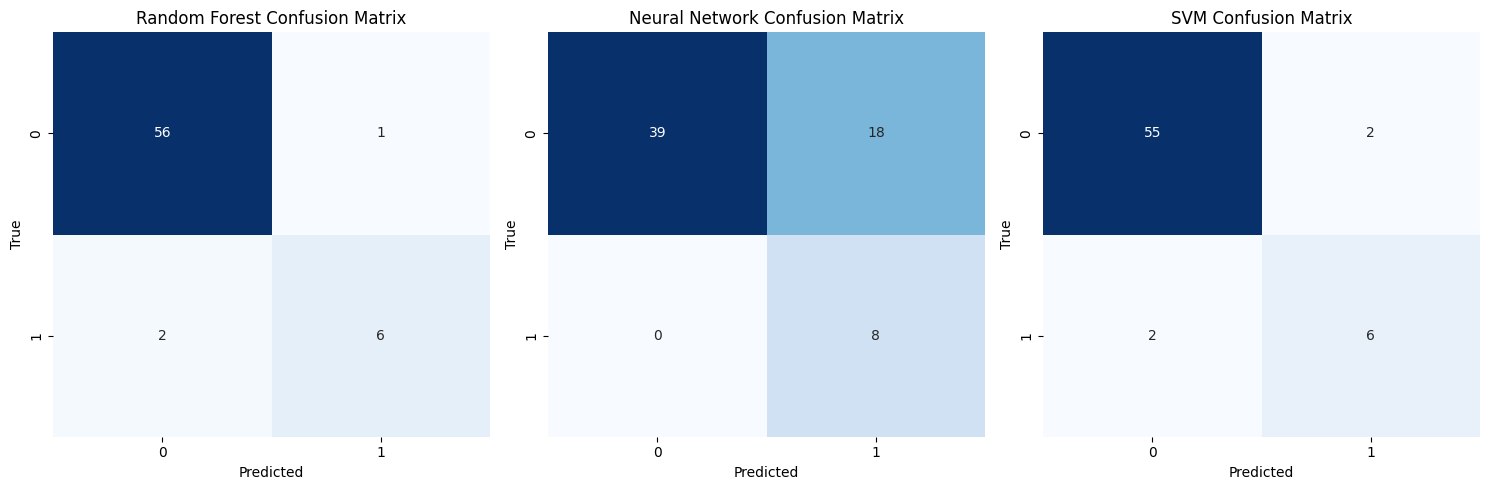

In [30]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1, 3, 2)
sns.heatmap(nn_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Neural Network Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1, 3, 3)
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

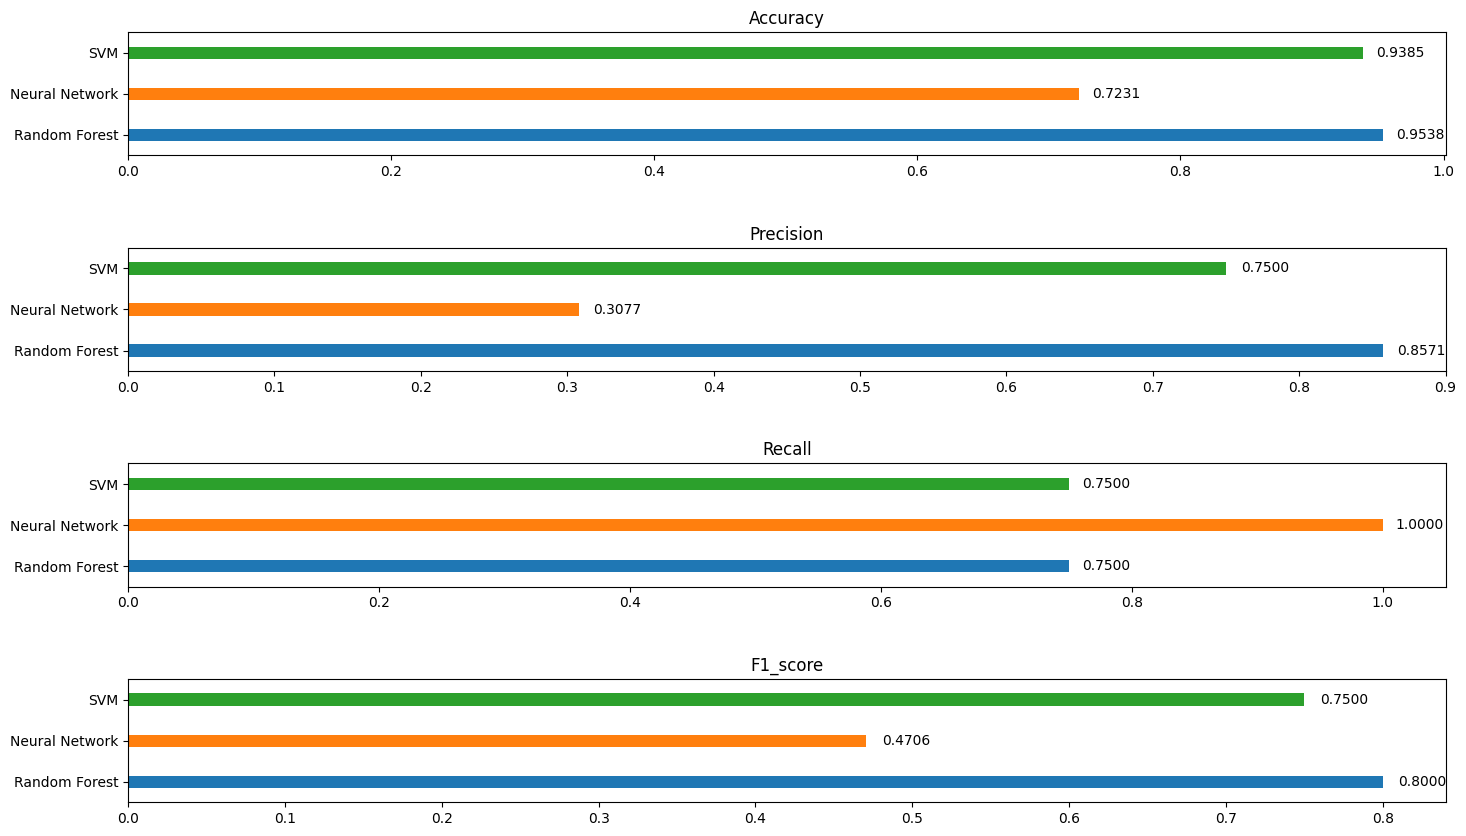

In [31]:
metrics = {'Random Forest': rf_metrics, 'Neural Network': nn_metrics, 'SVM': svm_metrics}
metrics_names = ['accuracy', 'precision', 'recall', 'f1_score']

fig, axes = plt.subplots(4, 1, figsize=(17, 10))  
colors = plt.cm.tab10(np.arange(len(metrics)))
bar_height = 0.3

for i, metric in enumerate(metrics_names):
    ax = axes[i]
    values = [m[metric] for m in metrics.values()]
    bars = ax.barh(np.arange(len(metrics)), values, color=colors, height=bar_height)
    ax.set_title(metric.capitalize())

    for bar, value in zip(bars, values):
        ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2, f'{value:.4f}', va='center')

    ax.set_ylim(-0.5, len(metrics) - 0.5)
    ax.set_yticks(np.arange(len(metrics)))
    ax.set_yticklabels(metrics.keys())

plt.subplots_adjust(hspace=0.75)
plt.show()
